# UMAP chess dataset EDA

---

## 1. Staging

---

import section:

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

import umap

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.compose import make_column_transformer

import tqdm.notebook as tqn
import pdb

### 1.1 Project parametrisation

1. General parameters
2. Vectorized moves table
3. Metadata table

#### 1.1.1 General parameters

In [2]:
## project
notebook_ver = 0.3
## input dataset
data_pth = './data/games.csv'

#### 1.1.2 Vectorized moves table parameters

#### 1.1.3 Metadata table params

In [3]:
## Define nominal data variables to be thrown at one-hot-encoder
to_hot_encode = [
    'opening_eco',
    'increment_code',
    'victory_status'
]

## Define string variables for str vectorization
to_vectorize = [
    'white_id',
    'black_id'
]

## Define numerical cols to use
num_cols = [
    'winner_bin',
    'rated_bin',
    'game_len_mins',
#     'turns', # dense var
#     'white_rating', # dense var
#     'black_rating', # dense var
    'opening_ply'
]

### 1.2 Functions

In [4]:
def to_uni(mov):
    '''
    Turn str move encoding into a sequence of Unicode values
    '''
    move_unicode = []
    for char in str(mov):
        move_unicode.append(ord(char))
    return move_unicode

In [5]:
def encode_moves(moves_seq):
    '''
    Encode move into an integer = 1*e^10
    '''
    moves = []

    for move in moves_seq.split(' '):
        ## Convert str encoding to unicode vals
        move_uni = to_uni(move)
        ## Multiply all unicode vals together
        move_prod = np.prod(np.array(move_uni))  
        ## Take log2 for every move and multiply by 10_000_000
        moves.append(int(np.log2(move_prod)*10_000_000))
    return(moves)

### 1.3 Data load 

In [6]:
GAMES = pd.read_csv(data_pth)

## 2. Preprocessing & initial dataset exploration

---

In [7]:
## Encode binary variables to integers
GAMES['rated_bin'] = np.where(GAMES['rated'] == True, 1, 0)

GAMES.drop(columns='rated',
          inplace=True)

In [8]:
GAMES['winner_bin'] = np.where(GAMES['winner'] == 'white', 0, 1)

GAMES.drop(columns='winner',
          inplace=True)

In [9]:
## Opening, closing games dates transformation
GAMES['created_at_dt'] = pd.to_datetime(GAMES['created_at']/1000, unit='s', origin='unix')
GAMES['last_move_at_dt'] = pd.to_datetime(GAMES['last_move_at']/1000, unit='s', origin='unix')

GAMES['game_len_dt'] = GAMES['last_move_at_dt'] - GAMES['created_at_dt']
GAMES['game_len'] = GAMES['last_move_at'] - GAMES['created_at']

GAMES['game_len_mins'] = GAMES['game_len_dt'].dt.components['minutes']

## 3. Vector formation

---

### 3.1 Vectorized moves table

In [10]:
## create a algebraic notation to iccf notation board mapping
# iccf_board = [str(x)+str(y) for x in range(1,9) for y in range(1,9)]
# algebraic_board = [l + str(i) for l in list('abcdefgh') for i in range(1,9)]
# board_mapping = {algebraic : iccf for algebraic, iccf in zip(algebraic_board, iccf_board)}

In [11]:
GAMES.columns

Index(['id', 'created_at', 'last_move_at', 'turns', 'victory_status',
       'increment_code', 'white_id', 'white_rating', 'black_id',
       'black_rating', 'moves', 'opening_eco', 'opening_name', 'opening_ply',
       'rated_bin', 'winner_bin', 'created_at_dt', 'last_move_at_dt',
       'game_len_dt', 'game_len', 'game_len_mins'],
      dtype='object')

In [12]:
## Encode moves into separate variable
GAMES['moves_encoded'] = GAMES['moves'].apply(lambda x: encode_moves(x))

In [13]:
GAMES.reset_index(inplace=True)

In [14]:
## Check max() len of moves sequence in dataset
moves_max = GAMES['turns'].max()

In [15]:
## Create Moves Table
MOVES = GAMES[['moves_encoded','id']]
MOVES.reset_index(inplace=True, drop=True)

MOVES

,moves_encoded,id
0,"[123442959, 123717766, 123297963, 123842441, 2...",TZJHLljE
1,"[123442959, 186696463, 123586512, 123861319, 1...",l1NXvwaE
2,"[123586512, 123861319, 123162815, 123987436, 1...",mIICvQHh
3,"[123442959, 123717766, 186302529, 184447399, 1...",kWKvrqYL
4,"[123586512, 123861319, 186302529, 123987436, 1...",9tXo1AUZ
...,...,...
20053,"[123442959, 124003457, 123306368, 124130989, 1...",EfqH7VVH
20054,"[123442959, 123987436, 184172591, 123861319, 1...",WSJDhbPl
20055,"[123442959, 123717766, 184172591, 186696463, 1...",yrAas0Kj
20056,"[123586512, 123987436, 123442959, 187127150, 1...",b0v4tRyF


In [16]:
## Form a vector out of moves_encoded variable
MOVES_EXPLODED = (MOVES
                .explode(column='moves_encoded'))

In [17]:
MOVES_EXPLODED.loc[1946]

moves_encoded    123589258
id                3K5kYPO8
Name: 1946, dtype: object

In [49]:
transposed_moves = []

for game in tqn.trange(0, len(MOVES_EXPLODED.index.unique())):
    
    GRABBED_MOVES = MOVES_EXPLODED.loc[game]
    cols = range(1,len(GRABBED_MOVES)+1)
    
    if type(GRABBED_MOVES['id']) is str:
        game_id = GRABBED_MOVES['id']
        GRABBED_MOVES_TR = GRABBED_MOVES.loc['moves_encoded']
        TRANS_MOVES = pd.DataFrame({1:GRABBED_MOVES_TR}, index=[game_id])
    else:
        game_id = GRABBED_MOVES['id'].unique()[0]
        GRABBED_MOVES_TR = GRABBED_MOVES.drop(columns='id')
        
        TRANS_MOVES = pd.DataFrame(GRABBED_MOVES_TR).T
        TRANS_MOVES.index = [game_id]
        TRANS_MOVES.columns = cols

    transposed_moves.append(TRANS_MOVES)

  0%|          | 0/20058 [00:00<?, ?it/s]

In [50]:
MOVES_TRANS = pd.concat(transposed_moves)

In [51]:
MOVES_TRANS.fillna(0, inplace=True)

In [52]:
MOVES_TRANS.iloc[1946]

1      123589258
2              0
3              0
4              0
5              0
         ...    
345            0
346            0
347            0
348            0
349            0
Name: 3K5kYPO8, Length: 349, dtype: int64

In [53]:
MOVES_TRANS.to_csv('./moves_trans.csv')

# @@@ Cell > Run All Above @@@

## Part 1 - Metadata table

---

In [ ]:
# ## Instantiate One Hot Encoder
# ohe = OneHotEncoder(handle_unknown='error')

In [ ]:
# ## Instantiate Count Vectorizer
# cve = CountVectorizer()

In [ ]:
# ## Set column transformer
# column_trans = make_column_transformer((ohe,to_hot_encode),
#                                        remainder='passthrough')

In [ ]:
# ## Fit column transformer
# column_trans.fit(GAMES[to_hot_encode])

In [ ]:
# ## Produce one-hot-encoded array 
# hot_array = column_trans.transform(games[to_hot_encode]).toarray()

# HOT_ENCODED = pd.DataFrame(hot_array, 
#                               columns = column_trans.get_feature_names())

In [ ]:
# ## Form final dataframe
# META = GAMES[num_cols].merge(HOT_ENCODED,
#                      left_index=True,
#                      right_index=True)

### Metadata table

In [ ]:
# META

## UMAP model

---

Parameters:

In [55]:
distance_metric = 'euclidean'
# metrics_available = euclidean, manhattan, chebyshev, minkowski, canberra, braycurtis, mahalanobis,
# wminkowski, seuclidean, cosine, correlation, haversine, hamming, jaccard, dice, russelrao, kulsinski,
# ll_dirichlet, hellinger, rogerstanimoto, sokalmichener, sokalsneath, yule

n_neighbors = 100
min_dist = 0.1

Instatiate & train the model:

In [56]:
## Instantiate UMAP model
reducer = umap.UMAP(metric=distance_metric,
                   n_neighbors=n_neighbors,
                   min_dist=min_dist,
                   n_epochs=500)

In [57]:
MOVES_TRANS.index.rename('id',inplace=True)

In [58]:
MOVES_TRANS.reset_index(drop=True, inplace=True)

In [59]:
MOVES_TRANS.to_csv('./vec.csv')

In [60]:
## Train the model
embedding = reducer.fit_transform(MOVES_TRANS)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


---

## Plot

---

Parameters:

In [68]:
## switches
cbar_switch = True

## display
alpha = 0.9
marker_shape = 'o'
marker_size = 4
dpi = 300

## data
cmap_variable = embedding[:,:1]

## colors
facecolor = 'black'
labelcolor = 'white'
cmap = 'viridis'

Plot script:

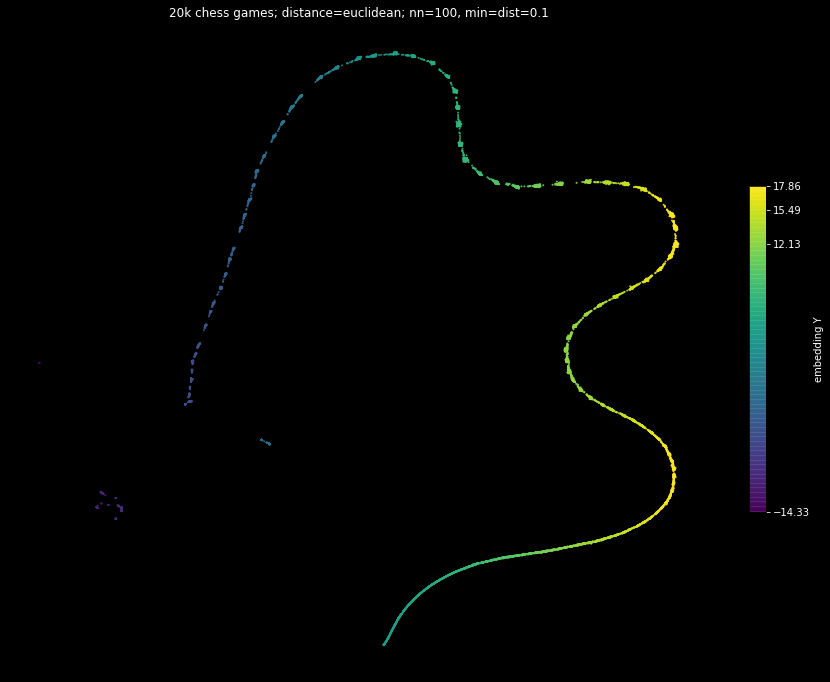

In [73]:
## Render vis
fig = plt.figure(figsize=(14,12))
fig.patch.set_facecolor(facecolor)

plot = plt.scatter(embedding[:,0], 
                embedding[:,1], 
                marker=marker_shape,
                s=marker_size,
                edgecolor='none',
                c=cmap_variable,
                cmap='viridis', 
                alpha=alpha)

plt.axis("off")
plt.title(f'20k chess games; distance={distance_metric}; nn={n_neighbors}, min=dist={min_dist}', 
          color='w')

if cbar_switch:
    cbar = plt.colorbar(fraction=0.05, 
                    shrink=0.5,
                    ticks=[cmap_variable.min(), 
                        np.quantile(cmap_variable,0.50),
                        np.quantile(cmap_variable,0.75),
                        cmap_variable.max()], alpha=alpha
                           )

    cbar.set_label('embedding Y', color=labelcolor)
    cbar.ax.yaxis.set_tick_params(color=labelcolor)
    cbar.solids.set_edgecolor("face")

plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color=labelcolor)

_ = plot

# plt.savefig(f"screens/{distance_metric}_nn{n_neighbors}_mind{min_dist}_v{notebook_ver}.png", 
#             dpi=dpi, 
#             facecolor=facecolor)